In [2]:
# Imports
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np

from matplotlib import pyplot as plt

import time

import pandas as pd

import urllib.request

In [16]:
# Model parameters
MASTER_CONFIG = {
    "vocab_size": 65,       # Number of unique characters in the dataset
    "batch_size": 32,       # Number of batches
    "context_window": 16,   # Number of characters in a batch
    "d_model": 128,         # Dimension of linear layers
    "epochs": 1000,         # Number of training epochs
    "log_interval": 10      # Frequency of logging the loss in epochs
}

# Data Preprocessing

In [4]:
# Tiny Shakespeare
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file_name = "tinyshakespeare.txt"
urllib.request.urlretrieve(url, file_name)

('tinyshakespeare.txt', <http.client.HTTPMessage at 0x7b45891e54e0>)

In [5]:
# Create vocab list of unique chars
lines = open("tinyshakespeare.txt", 'r').read()
vocab = sorted(list(set(lines)))

print("First 10 chars of vocab list:", vocab[:10])
print("Vocab size:", len(vocab))

First 10 chars of vocab list: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']
Vocab size: 65


In [6]:
# Int to string
itos = {i: ch for i, ch in enumerate(vocab)}

# String to int
stoi = {ch: i for i, ch in enumerate(vocab)}

In [7]:
# Encoding and decoding
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

# Example
print(encode("hello world"))
print(decode(encode("hello world")))

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]
hello world


In [8]:
# Convert dataset into a tensor
dataset = torch.tensor(encode(lines), dtype=torch.int8)

# Approximately 1 million tokens (chars)
print(dataset.shape)

torch.Size([1115394])


In [9]:
# Split dataset into train/val/test batches
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
  # Train/val/test split = 0.8/0.1/0.1
  train = data[:int(0.8 * len(data))]
  val = data[int(0.8 * len(data)):int(0.9 * len(data))]
  test = data[int(0.9 * len(data)):]

  # Determine which batch to use
  batch_data = train
  if split == "val":
    batch_data = val
  elif split == "test":
    batch_data = test

  # batch_size number of random starting points in the data
  ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

  # Input and target sequences
  x = torch.stack([batch_data[i:i + context_window] for i in ix]).long()
  y = torch.stack([batch_data[i + 1:i + context_window + 1] for i in ix]).long()

  return x, y

In [10]:
# Obtain batches for training
xs, ys = get_batches(dataset, "train", MASTER_CONFIG["batch_size"], MASTER_CONFIG["context_window"])

# Decode batches
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

# (sample, target)
print(decoded_samples)

[("This orb o' the ", "his orb o' the e"), ('ry the Sixth hat', 'y the Sixth hath'), ('safe.\n\nDUKE OF A', 'afe.\n\nDUKE OF AU'), (' great charms\nMi', 'great charms\nMis'), ('hes from an\ninch', 'es from an\ninch '), (',\nAnd, though mi', '\nAnd, though min'), ('body couched in ', 'ody couched in a'), ('u cannot tent yo', ' cannot tent you')]


# Loss

In [11]:
# Computes the mean loss for 10 batches for train/val
@torch.no_grad()
def evaluate_loss(model, config=MASTER_CONFIG):
  out = {}

  # Set the model to evaluation mode
  model.eval()

  # Iterate through train and val splits
  for split in ["train", "val"]:
    losses = []

    # Get 10 sample batches
    for _ in range(10):
      # Input and target sequences
      xb, yb = get_batches(dataset, split, config["batch_size"], config["context_window"])
      # Run the model and calculate the loss
      _, loss = model(xb, yb)
      losses.append(loss.item())

    out[split] = np.mean(losses)

  # Set the model to train mode
  model.train()

  return out

# Base Model

In [31]:
class BaseNN(nn.Module):
  def __init__(self, config=MASTER_CONFIG):
    super().__init__()
    self.config = config

    # Embedding layer to convert character indices to vectors
    self.embedding = nn.Embedding(config["vocab_size"], config["d_model"])
    # Linear layers
    self.linear = nn.Sequential(
        nn.Linear(config["d_model"], config["d_model"]),
        nn.ReLU(),
        nn.Linear(config["d_model"], config["vocab_size"])
    )

  def forward(self, idx, targets=None):
    # Embedding layer converts character indices to vectors
    x = self.embedding(idx)
    # Linear layers
    logits = self.linear(x)

    # If there are targets, calculate and return the cross entropy loss
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1, self.config["vocab_size"]), targets.view(-1))
      return logits, loss

    return logits

In [20]:
# Initialize model
model = BaseNN(MASTER_CONFIG)
print("Model parameters:", sum(p.numel() for p in model.parameters()))

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters())

Model parameters: 33217


In [21]:
# Calculate sample logits and loss
xs, ys = get_batches(dataset, "train", MASTER_CONFIG["batch_size"], MASTER_CONFIG["context_window"])
logits, loss = model(xs, ys)

print("Logits shape:", logits.shape)
print("Loss:", loss.item())

Logits shape: torch.Size([32, 16, 65])
Loss: 4.174921035766602


In [29]:
# Training loop
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
  losses = []
  start_time = time.time()

  # Iterate through epochs
  for epoch in range(config["epochs"]):
    # Zero out gradients
    optimizer.zero_grad()

    # Get training batches
    xs, ys = get_batches(dataset, "train", config["batch_size"], config["context_window"])
    # Run the model and calculate the loss
    logits, loss = model(xs, targets=ys)
    # Backpropagate the loss
    loss.backward()
    # Step the optimizer
    optimizer.step()

    # If there's a learning rate scheduler, adjust the learning rate
    if scheduler:
      scheduler.step()

    # Log progress
    if epoch % config["log_interval"] == 0:
      # Calculate batch time
      batch_time = time.time() - start_time

      # Evaluate loss
      x = evaluate_loss(model)
      losses += [x]

      # Print progress
      if print_logs:
        print(f"Epoch: {epoch} | Train loss: {x['train']:0.3f} | Val loss: {x['val']:0.3f} | Time: {batch_time:0.3f} | ETA in sec {batch_time * (config['epochs'] - epoch) / config['log_interval']:0.3f}")

      # Reset timer
      start_time = time.time()

      # Print learning rate
      if scheduler:
        print("Learning rate:", scheduler.get_last_lr())

  print("Val loss:", losses[-1]["val"])

  return pd.DataFrame(losses).plot()

Epoch: 0 | Train loss: 4.117 | Val loss: 4.115 | Time: 0.007 | ETA in sec 0.733
Epoch: 10 | Train loss: 3.575 | Val loss: 3.592 | Time: 0.050 | ETA in sec 4.903
Epoch: 20 | Train loss: 3.252 | Val loss: 3.188 | Time: 0.073 | ETA in sec 7.158
Epoch: 30 | Train loss: 2.967 | Val loss: 2.970 | Time: 0.077 | ETA in sec 7.446
Epoch: 40 | Train loss: 2.803 | Val loss: 2.899 | Time: 0.074 | ETA in sec 7.136
Epoch: 50 | Train loss: 2.795 | Val loss: 2.778 | Time: 0.077 | ETA in sec 7.302
Epoch: 60 | Train loss: 2.718 | Val loss: 2.655 | Time: 0.078 | ETA in sec 7.366
Epoch: 70 | Train loss: 2.701 | Val loss: 2.639 | Time: 0.070 | ETA in sec 6.547
Epoch: 80 | Train loss: 2.558 | Val loss: 2.772 | Time: 0.076 | ETA in sec 6.950
Epoch: 90 | Train loss: 2.611 | Val loss: 2.675 | Time: 0.078 | ETA in sec 7.111
Epoch: 100 | Train loss: 2.611 | Val loss: 2.693 | Time: 0.071 | ETA in sec 6.362
Epoch: 110 | Train loss: 2.551 | Val loss: 2.607 | Time: 0.069 | ETA in sec 6.184
Epoch: 120 | Train loss: 2.

<Axes: >

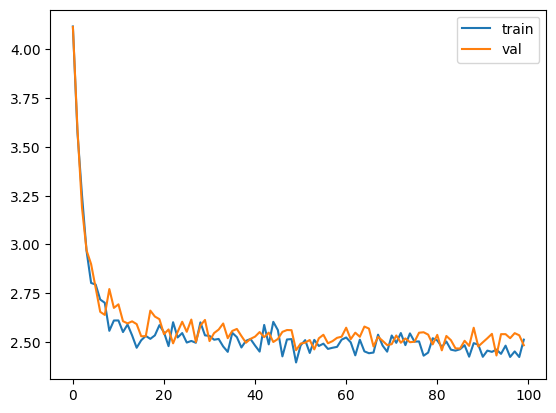

In [32]:
# Reinit model and optimizer
model = BaseNN(MASTER_CONFIG)
optimizer = torch.optim.Adam(model.parameters())

# Train model
train(model, optimizer, print_logs=True)

# Generating Text

In [52]:
# Generate text using the model
def generate(model, config=MASTER_CONFIG, num_texts=5, max_new_tokens=30):
  # Initialize with zeros = '\n'
  idx = torch.zeros(num_texts, 1).long()

  for _ in range(max_new_tokens):
    # Call the model
    logits = model(idx[:, -config["context_window"]:])
    # Get the newest logits: [all batches, last time step, all logits]
    last_time_step_logits = logits[:, -1, :]
    # Softmax probabilities
    p = F.softmax(last_time_step_logits, dim=-1)
    # Get the next token from the probabilities
    idx_next = torch.multinomial(p, num_samples=1)
    # Append the token
    idx = torch.cat([idx, idx_next], dim=-1)

  # Return the decoded tokens
  return [decode(x) for x in idx.tolist()]

In [53]:
generate(model)

['\nAMESos oofid;\nThin empthacel f',
 "\nAna cou ofo'sos;\n\nOner yolirt,",
 "\nNIstondwig exent'dsty tht,\n\nAn",
 '\nJUTEit CHo ns, lou me cck, ht,',
 '\nAlinge chainaiva owiscigh acth']